In [2]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

#feature of the house: area (square feet), n. of bedrooms, n. of floors and age.
X_train = np.array([[2104, 5, 1, 45], [1416, 3, 2, 40], [852, 2, 1, 35]])
#target variable: price of the house in $1000s
y_train = np.array([460, 232, 178])

# X is a matrix of shape (m, n) where m is the number of samples and n is the number of features.
print(X_train)

[[2104    5    1   45]
 [1416    3    2   40]
 [ 852    2    1   35]]


Notice that w (n, 1) and y (m, 1), so n. features vs n. of samples

In [3]:
b_init = 785.1811367994083 #IT'S A SCALAR!
w_init = np.array([ 0.39133535, 18.75376741, -53.36032453, -26.42131618])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (4,), b_init type: <class 'float'>


We have 2 possibilities for coding polynomial regression. Even if they could seem identical (cause the concept and math behind it'the same ) the usage of memory is very different (one is much faster when computed cause works in parallel, typical of GPUs): 

1) <font color='red'>Single prediction for one feature</font>

In [4]:
def predict_single_loop(x, w, b): 
    """
    single predict using linear regression
    
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters    
      b (scalar):  model parameter     
      
    Returns:
      p (scalar):  prediction
    """
    n = x.shape[0]
    p = 0
    for i in range(n):
        p_i = x[i] * w[i]  
        p = p + p_i         
    p = p + b                
    return p

# get a row from our training data
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

x_vec shape (4,), x_vec value: [2104    5    1   45]


Now we're gonna make a prediction based only on the first feature

In [ ]:
f_wb = predict_single_loop(x_vec, w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb:.2f}")

f_wb shape (), prediction: 460.00


2) <font color='red'>Single prediction using vector of features</font>

In [9]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b     
    return p  

# like before, we take a slice and make a prediction
x_vec = X_train[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb:.2f}")

x_vec shape (4,), x_vec value: [2104    5    1   45]
f_wb shape (), prediction: 460.00


The value clearly is the same, but again if we measure the time we'll notice the difference. Obviously in bigger models this is game-changing. 
So far we didn't mention how to get w and b, the elephant in the room in fact it's the

<font color= 'red'>**COST FUNCTION**</font>

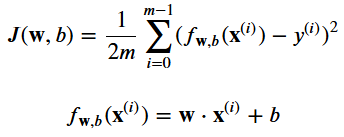

In [10]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_train, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 1.5578904880036537e-12


Then we can use it for the gradient discent, that now is computed from multiple variables
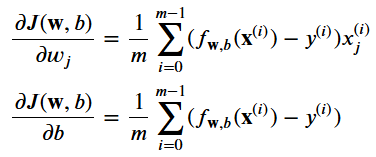

In [11]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: -1.673925169143331e-06
dj_dw at initial w,b: 
 [-2.73e-03 -6.27e-06 -2.22e-06 -6.92e-05]


And now we can succesfully compute the gradient: 
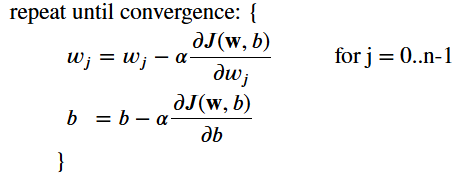

In [13]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 1000
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

Iteration    0: Cost  2529.46   
Iteration  100: Cost   695.99   
Iteration  200: Cost   694.92   
Iteration  300: Cost   693.86   
Iteration  400: Cost   692.81   
Iteration  500: Cost   691.77   
Iteration  600: Cost   690.73   
Iteration  700: Cost   689.71   
Iteration  800: Cost   688.70   
Iteration  900: Cost   687.69   
b,w found by gradient descent: -0.00,[ 0.2   0.   -0.01 -0.07] 
prediction: 426.19, target value: 460
prediction: 286.17, target value: 232
prediction: 171.47, target value: 178


And now let's plot some interesting info on cost function and iterations

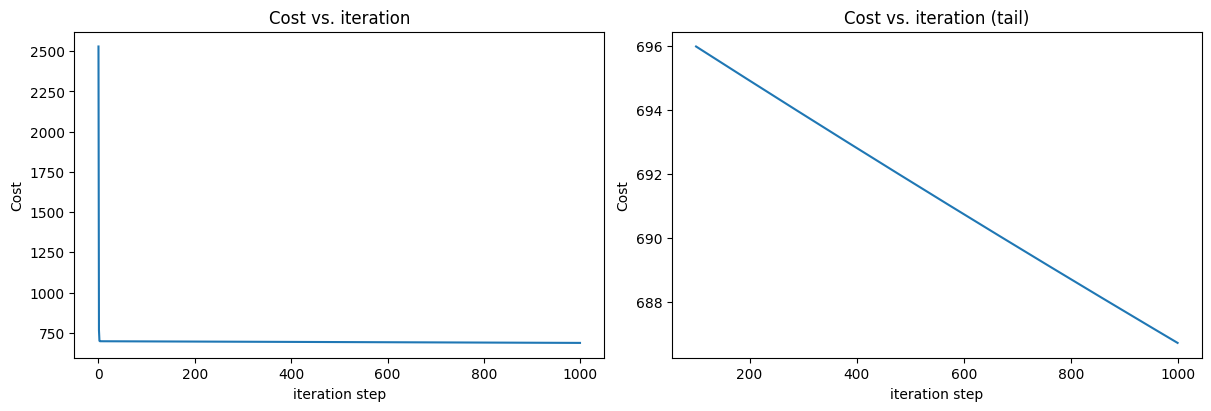

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()